In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time, timedelta


In [72]:
pwd

'/Users/domburrin/Desktop/True_Beacon '

In [73]:
#Load the data, fill missing values with the row before for completeness. 
df = pd.read_parquet('data.parquet', engine='pyarrow').fillna(method='ffill')

In [74]:
#We first create a simple z score function to calculate all Z-Scores of a given time series.
def z_scores(spread):
    return (spread - spread.mean()) / (spread.std())

In [75]:
#As stated, indian market hours are between 09:15 and 15:30 so we can only make trades in these hours:
def can_trade(current_time):
    if (time(9, 15) <= current_time <= time(15, 30)):
        return True
    else:
        return False

In [76]:
#Create some new columns of our data, for plotting purposes.
df['Spread'] = df['banknifty'] - df['nifty']
df['Z Scores'] = (df['Spread'] - df['Spread'].mean()) / (df['Spread'].std())

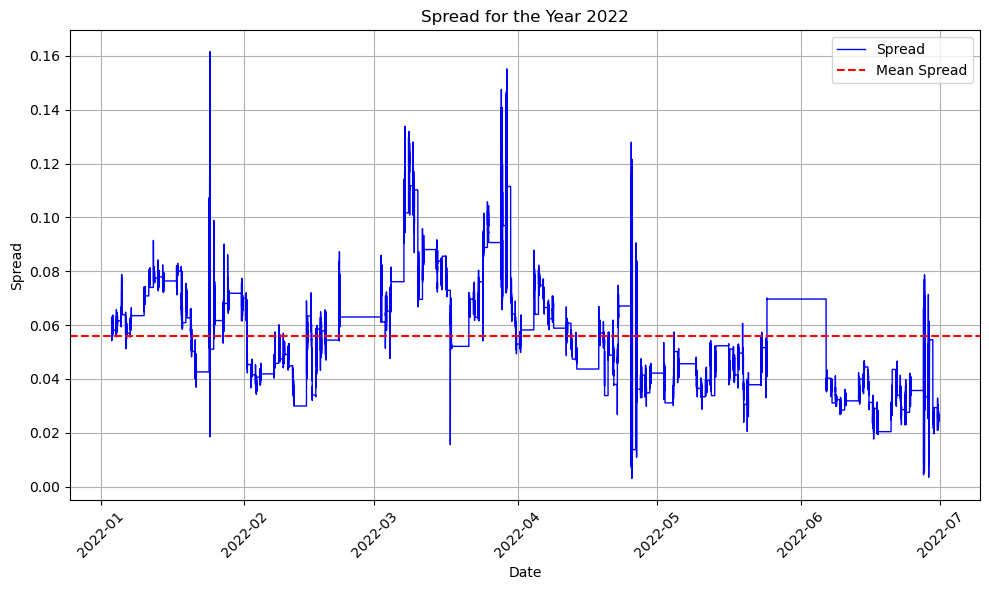

In [77]:
#General Idea for why pairs trading works, let us plot the spread against time for 2022.

start_date = '2022-01-01'
end_date = '2022-06-30'
df_filtered = df.loc[start_date:end_date]

mean_spread = df_filtered['Spread'].mean()

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(df_filtered.index, df_filtered['Spread'], label='Spread', color='blue', linewidth=1)
plt.axhline(mean_spread, color='red', linestyle='--', label='Mean Spread')
plt.title('Spread for the Year 2022') 
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotates the x-axis labels to make them more readable
plt.tight_layout()  

plt.show()

In [78]:
#This plot shows us the variation of spread. It fluctuates constantly around the mean.
#This illustrates how our thesis that the spread will eventually return to its mean has good foundation.

In [79]:
#Later we will need this function for computing sharpe ratios and drawdown. 
#It changes a daily pnl time series dictionary into percentage daily returns for a given starting cash
#(We need starting cash so that the percentage returns aren't unbounded, since some days we make no money)

def daily_pnl_to_returns(daily_pnl, initial_investment):

    # Convert daily P&L dictionary to a pandas Series
    daily_pnl_series = pd.Series(daily_pnl)
    
    # Calculate cumulative P&L
    cumulative_pnl = daily_pnl_series.cumsum()
    
    # Calculate daily portfolio value by adding cumulative P&L to the initial investment
    daily_portfolio_value = cumulative_pnl + initial_investment
    
    # Calculate daily returns as percentage change in portfolio value
    daily_returns = daily_portfolio_value.pct_change().fillna(0)
    
    return daily_returns

In [80]:
#Question 1: The Z Score trading algorithm.


def z_score_trade_costs(BN, N, T):
    
    spread = BN - N
    zscore = z_scores(spread)
    
    p_l = 0                            #Overall P/L
    spread_at_trade = 0                #Records the spread when we make a trade.
    number_of_longs = 0                #Tracks how many times we go long on the spread
    is_long = False                    #Tracks if we are long on the spread
    number_of_shorts = 0               #Tracks how many times we go short on the spread
    is_short = False                   #Tracks if we are short on the spread
    no_of_liquidations =0              #Tracks the number of times we liquidate a trade (buy it back or sell it)
    trade_time = None                  #Records the time at which we go long/short
    daily_p_l = {}                     #Tracks daily p/l, used for sharpe ratio
    
    for i in range(len(spread)):
        current_datetime = spread.index[i]       #Current date and time of our row
        current_time = current_datetime.time()   #Extract the time part of the datetime index
        current_day = current_datetime.date()    #Extract the day of our datetime index
        
        if current_day not in daily_p_l:         #For sharpe ratio, completeness of dictionary
            daily_p_l[current_day] = 0           
        
        #First Signal : If Z-Score > 1.2, we want to short the spread (Sell Bank Nifty, Buy Nifty).
        
        
        if zscore[i] > 1.2 :
            if (can_trade(current_time)) and (not is_long and not is_short) :     #Can only trade if we are in market hours  
                                                                                  #& Only Trade if we have no positions
                    spread_at_trade = spread[i]                                   #Record what our spread is at this time
                    number_of_shorts += 1                                         #We go short one time
                    is_short = True                                               #Now short on the spread
                    trade_time = spread.index[i]                                  #Record the datetime of the trade
                
       
        #Second Signal : If Z-Score < -1.2, we want to go long on the spread (Buy Bank Nifty, Sell Nifty)
        
        elif zscore[i] <-1.2 :
            if (can_trade(current_time)) and (not is_long and not is_short):      #Now do the opposite of above.
                    spread_at_trade = spread[i]  
                    number_of_longs += 1
                    is_long = True
                    trade_time = spread.index[i]
        
                
        #Now want to create exit signals
        #We check if we are allowed to exit, i.e we need to be in the medium frequency trading zone.
        
        if trade_time is not None:
            time_since_trade = current_datetime - trade_time                   #Allows us to check how long our position is held
        
            if timedelta(minutes=30) <= time_since_trade < timedelta(days=5):  #Medium Frequency Trading
        
                if abs(zscore[i]) < 0.75 and can_trade(current_time):          #Exit point is between -0.75 and 0.75
                    if is_long or is_short:
                        # Calculate P/L based on whether we're long or short
                        
                        #Our profit is always sell 'price' - buy 'price'
                        #If we were long/short on the spread, our profit is (spread when we sell - spread when we buy) * (tte**0.7) 
                        
                        profit_loss = (spread[i] - spread_at_trade) * (T[i]**0.7) if is_long else (spread_at_trade - spread[i]) * (T[i]**0.7)
                        p_l += 0.99 * profit_loss     #Here, I use a discounted addition due to trades being free and I wanted to represent transaction fees
                        daily_p_l[current_day] += profit_loss    #Update our daily pnl
                        spread_at_trade = 0
                        no_of_liquidations += 1
                        is_long = False
                        is_short = False
                        trade_time = None    #Resets our variables so we can trade again
        
            
            #If we still have a position at T=5 days from the trade then liquidate
            if time_since_trade >= timedelta(days=5) and (is_long or is_short):
                
                # Calculate P/L for either long or short positions
                
                profit_loss = (spread[i] - spread_at_trade) * (T[i]**0.7) if is_long else (spread_at_trade - spread[i]) * (T[i]**0.7)
                p_l += 0.99 * (profit_loss)
                daily_p_l[current_day] += profit_loss
                spread_at_trade = 0
                no_of_liquidations += 1
                is_long = False
                is_short = False
                trade_time = None
    
    daily_returns = daily_pnl_to_returns(daily_p_l, 100)  #Uses earlier formula to calculate daily returns, 100 initial cash.
    
                
                
                    
    return [p_l, number_of_longs , number_of_shorts , no_of_liquidations, daily_returns]


In [81]:
z_score_model = z_score_trade_costs(df['banknifty'], df['nifty'], df['tte']) #Create Variable for our df

In [82]:
#My idea for question 2 is to use Bollinger Bands as trading signals. Again, we will work with the spread of
#the data and before building the model let us plot a graph like we did in question 1 to visually analyse
#what these Bollinger Bands are, and when we would potentially make trades based off of them.

#We will pick a random trading day to do this, so the graph is clearer to see since our time series is minutely.

In [83]:
#Make the columns
window = 20
k = 2

# Middle Band (Rolling Mean)
df['middle_band'] = df['Spread'].rolling(window=window).mean()

# Standard Deviation
df['std_dev'] = df['Spread'].rolling(window=window).std()

# Upper Band
df['upper_band'] = df['middle_band'] + (df['std_dev'] * k)

# Lower Band
df['lower_band'] = df['middle_band'] - (df['std_dev'] * k)

# Long Entry Points
df['long_entry'] = df['Spread'] < df['lower_band']

# Short Entry Points
df['short_entry'] = df['Spread'] > df['upper_band']

#Now plot these columns
def plot_bollinger_bands(df, start_date, end_date):
   
    # Filter the DataFrame for the specified date range
    filtered_df = df.loc[start_date:end_date]

    plt.figure(figsize=(14, 7))

    # Plot Spread and Bollinger Bands
    plt.plot(filtered_df.index, filtered_df['Spread'], label='Spread', color='blue')
    plt.plot(filtered_df.index, filtered_df['middle_band'], label='Rolling Mean', color='black', linestyle='--')
    plt.plot(filtered_df.index, filtered_df['upper_band'], label='Upper Band', color='red', linestyle='--')
    plt.plot(filtered_df.index, filtered_df['lower_band'], label='Lower Band', color='green', linestyle='--')
    
    # Long Entry Points marked with blue crosses
    buy_entries = filtered_df[filtered_df['long_entry']]
    plt.scatter(buy_entries.index, buy_entries['Spread'], color='blue', label='Buy Entry', marker='x', s=100)
    
    # Short Entry Points marked with red crosses
    short_entries = filtered_df[filtered_df['short_entry']]
    plt.scatter(short_entries.index, short_entries['Spread'], color='red', label='Short Entry', marker='x', s=100)


    plt.title(f'Spread and Bollinger Bands from {start_date} to {end_date}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

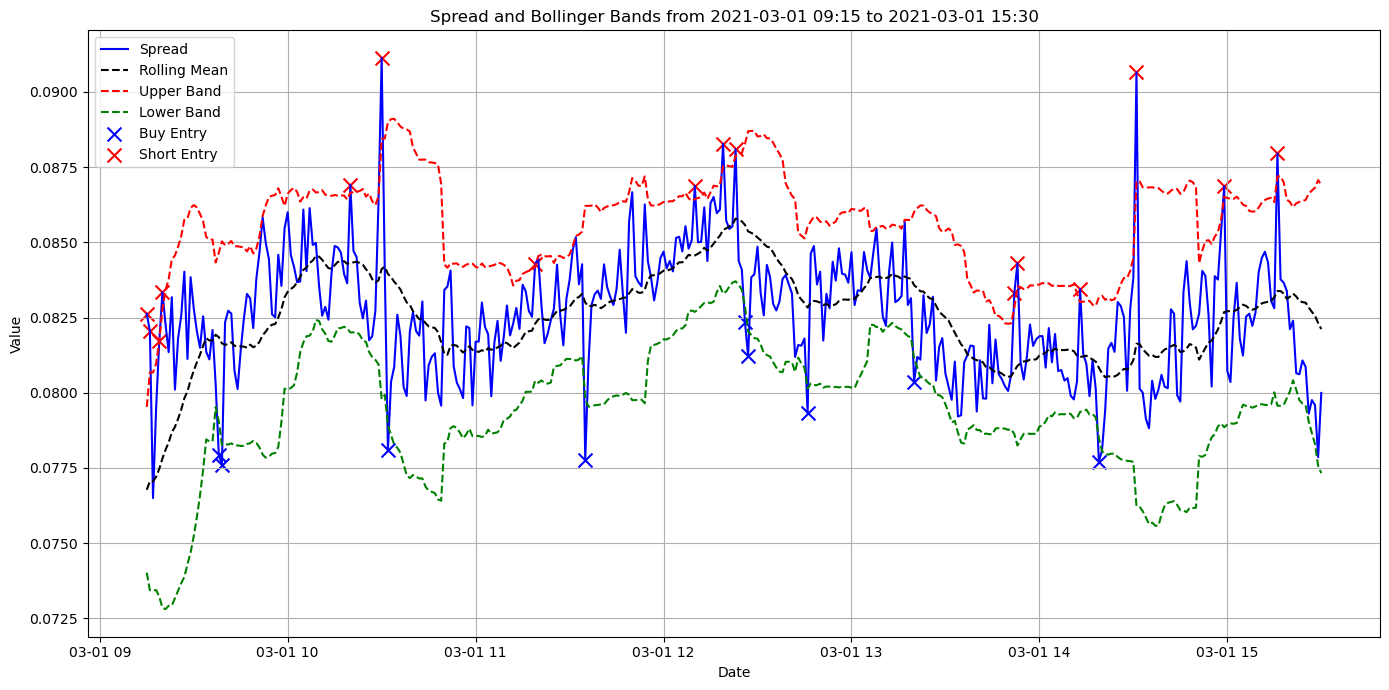

In [84]:
plot_bollinger_bands(df, '2021-03-01 09:15', '2021-03-01 15:30')

In [85]:
#We can see how the spread varies over 1 day, and how it generally moves out of these bands, and then back to the 
#mean. 

#One downside of this model is that it probably works better with high frequency trading as opposed to 
#medium frequency, since the graph shows that when it moves out of the Bollinger Bands, it usually moves quickly
#back in.

In [86]:
#Furthermore, a side note:

#I noticed in there are a lot of certain time periods we get a constant spread.
#I analysed this and it is where for prolonged periods of times, the two IV values of Bank Nifty and Nifty are 
#constant. I assume there is some reason for this, most of when this occurs is outside of trading hours so perhaps
#we assume there is no change in implied volatility overnight.

#I will keep this data in, since for my models it shouldn't affect any trading signals due to the nature of them.

In [87]:
#Question 2, a better model.

def bollinger_bands_trade_costs(BN, N, T):
    
    spread = BN - N
    window = 20                        #Window for rolling mean/std
    k = 2                              #How many standard deviations from the mean 
    
    p_l = 0                            #Overall P/L
    spread_at_trade = 0                #Used in P/L Calculation
    number_of_longs = 0                #Tracks how many times we go long on the spread
    is_long = False                    #Tracks if we are long on the spread
    number_of_shorts = 0               #Tracks how many times we go short on the spread
    is_short = False                   #Tracks if we are short on the spread
    no_of_liquidations =0              #Tracks the number of times we liquidate
    trade_time = None                  #Records the time at which we go long/short
    daily_p_l = {}                     #Tracks daily pnl
    
    middle_band = spread.rolling(window = window).mean()   #These are the bollinger bands for our data 
    std_dev = spread.rolling(window = window).std()
    upper_band = middle_band + (std_dev * k)
    lower_band = middle_band - (std_dev * k)
    
    for i in range(21,len(spread)):                        #Don't have data for first 20 due to window
        current_datetime = spread.index[i]       
        current_time = current_datetime.time()   
        current_day = current_datetime.date()
        
        if current_day not in daily_p_l:
            daily_p_l[current_day] = 0
        
        #First Signal : If spread[i] > upper band : Short
        
        if spread[i] > upper_band[i] and not is_short and not is_long and can_trade(current_time):   
            spread_at_trade = spread[i]   #Record what our spread is at this time
            number_of_shorts += 1         #We go short one time
            is_short = True               #Now short on the spread
            trade_time = spread.index[i]
                
       
        #Second Signal : If spread[i] < lower band : Long
        
        elif spread[i] < lower_band[i] and not is_long and not is_short and can_trade(current_time):
            spread_at_trade = spread[i]  
            number_of_longs += 1
            is_long = True
            trade_time = spread.index[i]
        
                
        #Exit signals, if we cross the middle band from below when long OR vice versa.
        
        if trade_time is not None:
            time_since_trade = current_datetime - trade_time  #Allows us to check how long our position is held
        
            if timedelta(minutes=30) <= time_since_trade < timedelta(days=5):  #Medium Frequency Trading
                
                if ((is_long and spread[i] >= middle_band[i]) or (is_short and spread[i] <= middle_band[i])) and can_trade(current_time): 
                     
                    if is_long:
                        profit_loss = (spread[i] - spread_at_trade) * (T[i]**0.7)
                        p_l += 0.99 * (profit_loss)  # Calculate profit or loss based on exit condition
                        daily_p_l[current_day] += profit_loss
                    if is_short:
                        profit_loss = (spread_at_trade - spread[i]) * (T[i]**0.7)
                        p_l += 0.99 * (profit_loss)
                        daily_p_l[current_day] += profit_loss
                    
                    
                    is_long = False
                    is_short = False
                    no_of_liquidations += 1
                    trade_time = None             #Resets our variables so we can trade again
        
            
            #If we still have a position at T=5 days from the trade then liquidate
            if time_since_trade == timedelta(days=5) and (is_long or is_short):
                if is_long:
                    profit_loss = (spread[i] - spread_at_trade) * (T[i]**0.7)
                    p_l = p_l + 0.99 * (profit_loss)
                    daily_p_l[current_day] += profit_loss
                if is_short:
                    profit_loss = (spread_at_trade - spread[i]) * (T[i]**0.7)
                    p_l = p_l + 0.99 *  (profit_loss)
                    daily_p_l[current_day] += profit_loss
                
                # Reset state
                is_long = False
                is_short = False
                no_of_liquidations += 1
                trade_time = None
                
    daily_returns = daily_pnl_to_returns(daily_p_l, 100)    #Creates daily returns again 
                
                
                    
    return [p_l, number_of_longs , number_of_shorts , no_of_liquidations , daily_returns]

In [88]:
bollinger_model = bollinger_bands_trade_costs(df['banknifty'], df['nifty'], df['tte'])

In [89]:
#Now for some analysis of the two models. We create the functions to calculate sharpe ratio and drawdown of a 
#portfolio

In [90]:
def calculate_sharpe_ratio(daily_returns):              #For simplicity, I assume a risk free rate of 0
    return daily_returns.mean() / daily_returns.std()

In [91]:
def calculate_max_drawdown(daily_returns):
    
    # Calculate the cumulative product as by the formula
    cumulative_returns = (1 + daily_returns).cumprod()
    # Calculate the running maximum
    running_max = cumulative_returns.cummax()
    # Calculate drawdowns
    drawdowns = (cumulative_returns - running_max) / running_max
    # Find the maximum drawdown
    max_drawdown = drawdowns.min()  # Drawdowns are negative, so the minimum is the largest in magnitude
    
    return -100*max_drawdown #Return as a positive percentage

In [92]:
#Now I make a function to compare any two generic models, which takes two arguments, which are 5-tuples and
#compares the P/L, Sharpe Ratio, Number of Trades and Drawdown.
#I decided to add in the number of trades comparison as it it an extra way to compare and constrast the models 
#aside from general SR, P/L etc.

In [93]:
def compare_models(model1, model2):
    metrics = ['P/L', 'number of longs', 'number of shorts', 'number of liquidations']
    
    sharpe_ratio_model1 = calculate_sharpe_ratio(model1[-1])
    sharpe_ratio_model2 = calculate_sharpe_ratio(model2[-1])
    
    max_drawdown_model1 = calculate_max_drawdown(model1[-1])
    max_drawdown_model2 = calculate_max_drawdown(model2[-1])
    
    for i, metric in enumerate(metrics):
        model1_value = f"{model1[i]:.2f}" if metric == 'P/L' else model1[i]
        model2_value = f"{model2[i]:.2f}" if metric == 'P/L' else model2[i]
        
        if model1[i] < model2[i]:
            print(f"The {metric} of Model 1 is {model1_value}, versus {metric} of Model 2 is {model2_value}, so the {metric} of Model 2 is higher.")
            if metric == 'P/L':
                print("Having a higher P/L indicates that Model 2 is more profitable.")
            elif metric in ['number of longs', 'number of shorts']:
                print(f"A higher {metric} suggests that Model 2 engages in more frequent trading opportunities in this direction.")
            elif metric == 'number of liquidations':
                print("More liquidations might indicate more active trade management or more frequent signal changes in Model 2.")
        elif model1[i] > model2[i]:
            print(f"The {metric} of Model 1 is {model1_value}, versus {metric} of Model 2 is {model2_value}, so the {metric} of Model 1 is higher.")
            if metric == 'P/L':
                print("Having a higher P/L indicates that Model 1 is more profitable.")
            elif metric in ['number of longs', 'number of shorts']:
                print(f"A higher {metric} suggests that Model 1 engages in more frequent trading opportunities in this direction.")
            elif metric == 'number of liquidations':
                print("More liquidations might indicate more active trade management or more frequent signal changes in Model 1.")
        else:
            print(f"The {metric} is equal for both models, with a value of {model1_value}.")
        
        
    if sharpe_ratio_model1 != sharpe_ratio_model2:
        higher = "Model 1" if sharpe_ratio_model1 > sharpe_ratio_model2 else "Model 2"
        print(f"Sharpe Ratio of Model 1 is {sharpe_ratio_model1:.2f}, versus Sharpe Ratio of Model 2 is {sharpe_ratio_model2:.3f}.")
        print(f"Thus, the Sharpe Ratio of {higher} is higher, indicating a better risk-adjusted return.")
    else:
        print(f"Both models have an equal Sharpe Ratio of {sharpe_ratio_model1:.3f}.")
        
    print(f"Maximum Drawdown of Model 1 is {max_drawdown_model1}%, versus Maximum Drawdown of Model 2 is {max_drawdown_model2}%.")
    if max_drawdown_model1 != max_drawdown_model2:
        #For drawdown, a lower (less negative or more positive) number is better
        better = "Model 1" if max_drawdown_model1 < max_drawdown_model2 else "Model 2"
        print(f"Thus, {better} has a lower Maximum Drawdown, indicating better risk management.")

In [96]:
compare_models(z_score_model, bollinger_model)

The P/L of Model 1 is 33.59, versus P/L of Model 2 is 72.13, so the P/L of Model 2 is higher.
Having a higher P/L indicates that Model 2 is more profitable.
The number of longs of Model 1 is 71, versus number of longs of Model 2 is 1252, so the number of longs of Model 2 is higher.
A higher number of longs suggests that Model 2 engages in more frequent trading opportunities in this direction.
The number of shorts of Model 1 is 85, versus number of shorts of Model 2 is 1217, so the number of shorts of Model 2 is higher.
A higher number of shorts suggests that Model 2 engages in more frequent trading opportunities in this direction.
The number of liquidations of Model 1 is 155, versus number of liquidations of Model 2 is 2468, so the number of liquidations of Model 2 is higher.
More liquidations might indicate more active trade management or more frequent signal changes in Model 2.
Sharpe Ratio of Model 1 is 0.18, versus Sharpe Ratio of Model 2 is 0.415.
Thus, the Sharpe Ratio of Model 2

In [97]:
#Assumptions made throughout the assignment:

#Firstly, on dealing with the data. I used the 'fillna' method to identify where there are NA values and fill them
#with the same value as the row before. Generally since the time series is minutely, this seems like a good approach
#and when I compared it to dropping the NA values all together, it gave very similar values for the P/L, number
#of trades, etc, whilst maintaing the completeness of the data.

#An assumption for pairs trading to work is that the two indexes' volatilities are highly correlated.
#Since this was stated as the assumption before the assignment, I have assumed it as true and to visualise it, 
#plotted graphs throughout which generally show good signs that they are correlated. If we wanted to analyse this
#further, we could use tests such as Pearson correlation, Spearman etc.

#Next, in my models I assumed a small transaction fee to make it more realistic. This was present when calculating
#p/l in the 0.99 factor, since the second model was making a lot more trades, and I didn't want it to be a simple 
#case of more trades = more money so I added this in.

#Parameter selection: For both models I researched the best parameters to use for the entry and exit points. For
#Z-Scores I found entry points were +-1.2, and then exit between +-0.75. For Bollinger Bands I found k = 2 as a 
#standard for the multiplier. Further optimization could be carried out to analyse what the exact parameters 
#best-suited to these indexes are.

#Finally, I assumed that the general 'Medium Frequency Trading' limits given to me were strict. For example True 
#Beacon would not want any positions held longer than 5 days strictly, and so if we got to T = 5 days and we were
#still long or short, I sold/bought at that minute, regardless of the spread. The same goes for only liquidating
#positions more than 30 minutes after making that trade.


In [70]:
#Summary and Findings

#As stated in the comparison function, Model 2 outperforms Model 1 everywhere.
#It has ~115% higher P/L and a ~131% higher Sharpe Ratio.

#Both models however have a low Sharpe Ratio overall. A Sharpe Ratio below 1 is sub-optimal, and so this is a 
#downside of the models. To improve this, further analysis and research would need to be done on the correlation
#and most optimal times to trade.

#The Drawdown of both strategies are very low indicating they do not carry a lot of risk which is an advantage of 
#the algorithms. This is due to the fact that a lot of the days, we may not make trades since the spread does not
#break out of the limit it needs to and so we get smaller changes in our returns and hence less volatile returns. 

#My second model makes a lot more trades. It makes a total of 2468 trades whereas model 1 makes only 155. Over a 
#year and a half, 2468 trades is far more realistic for a medium frequency trading strategy, but as I mentioned 
#earlier, with this data it is likely that model 2 would actually perform better in a high frequency system. 

#Overall, both models provide an insight into how we can take advantage of two indexes, stocks, (or even assets 
#across different classes, such as a currency and oil product) being correlated and make money on the spread of 
#them. I chose the Bollinger Bands idea because it is used to identify opportunities where the spead is 'overbought'
#or 'oversold' and hence provides a simple yet effective way to make a profit based on this thesis.